In [5]:
import random
import numpy as np

import initialization
import evaluation
import parent_selection
import crossover
import survivor_selection
import environment
import mutation

import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
class BinsEA:

    def __init__(self, bin_info=environment.BinInfo('../datasets/BinLocations_Medium.csv', '../datasets/BinDistances_Medium.csv'), 
                 pop_size=120, mating_pool_size=80, tournament_size=20, crossover_rate=0.3, mut_rate=0.8, max_gen=3000, target=12, crossover_type=0, eval_type=0):
        
        self.crossover_type=crossover_type
        self.eval_type=eval_type
        self.bin_info=bin_info
        self.pop_size=pop_size
        self.mating_pool_size=mating_pool_size
        self.tournament_size=tournament_size
        self.crossover_rate=crossover_rate
        self.mut_rate=mut_rate
        self.max_gen=max_gen
        self.target=target

    def get_output(self, display=True):

        bin_count = len(self.bin_info.bins)
        #List of the average route length for each generation
        avg_dist = []

        # Initialization
        population = initialization.pop_init(self.pop_size, self.bin_info, bin_count)
        fitness = [] # Fitness ranges from 0 to bin_count
        for i in population:
            fitness.append(evaluation.fitness(i, self.bin_info, self.eval_type))
        gen = 0
        og_fitness = fitness.copy()
        # Main Evolutionary Loop
        while (gen < self.max_gen and max(fitness) < self.target):

            parents = parent_selection.tournament_select(population, fitness, self.mating_pool_size, self.tournament_size)
            random.shuffle(parents)
            offspring = []
            offspring_fitness = []
            
            i=0
            while len(offspring) < self.mating_pool_size - 1:
                # PMX is used to create 2 offspring at a time
                if self.crossover_type == 0 :
                    off = crossover.crossover_main(population[parents[i]], population[parents[i+1]], self.crossover_rate, 0)
                    # Performs inversion mutation on offspring
                    off1 = mutation.inv_mut(off[0],self.mut_rate)
                    off2 = mutation.inv_mut(off[1],self.mut_rate)
                    offspring.append(off1)
                    offspring.append(off2)
                    offspring_fitness.append(evaluation.fitness(off1,self.bin_info,self.eval_type))
                    offspring_fitness.append(evaluation.fitness(off2,self.bin_info,self.eval_type))
                    i += 2
                # Edge Crossover is used to create 1 offspring at a time
                else: 
                    off = crossover.crossover_main(population[parents[i]], population[parents[i+1]], self.crossover_rate, 1)
                    off = mutation.inv_mut(off,self.mut_rate)
                    offspring.append(off)
                    offspring_fitness.append(evaluation.fitness(off,self.bin_info,self.eval_type))
                    i += 1

            population, fitness = survivor_selection.mu_plus_lambda(population, fitness, offspring, offspring_fitness)
            if(display):
                print("gen: ",gen," - max fit: ",max(fitness)," - pop size: ", len(population))
            avg_dist.append(len(population[0]) / (sum(fitness)/len(fitness)))

            gen += 1

        return population, fitness, og_fitness, gen, avg_dist

In [ ]:
bin_info = environment.BinInfo('../datasets/BinLocations_Medium.csv', '../datasets/BinDistances_Medium.csv')

pop_size = 120
# Mating pool size must be even
mating_pool_size = 80 
tournament_size = 20
crossover_rate = 0.3
mut_rate = 0.7

max_gen = 3000
target_fitness = 12
crossover_type = 0 # 0: PMX, 1: Edge Crossover
eval_type = 0 # 0: Uses long/lat, 1: uses long/lat and direction

gen_count = 0
model = BinsEA(bin_info, pop_size, mating_pool_size, tournament_size, crossover_rate, mut_rate, max_gen, target_fitness, crossover_type, eval_type)
population, fitness, fitness_o, gen_count, avg_dist = model.get_output()
route = population[fitness.index(max(fitness))]
route_distance = 0
for bin in range(len(route)-1):
        route_distance += bin_info.get_dist(route[bin], route[bin+1])

#### Basic Summary

Best Individual: [98, 97, 91, 93, 96, 92, 94, 90, 99, 95, 19, 17, 11, 57, 36, 82, 28, 49, 6, 77, 80, 51, 68, 8, 65, 81, 38, 46, 14, 23, 66, 72, 62, 21, 26, 1, 12, 70, 74, 83, 88, 33, 3, 54, 35, 78, 13, 76, 63, 5, 48, 10, False, 40, 47, 42, 86, 34, 20, 89, 58, 37, 53, 39, 61, 84, 56, 16, 30, 15, 64, 59, 29, 75, 22, 87, 41, 4, 69, 9, 85, 24, 44, 52, 31, 55, 2, 67, 71, 73, 45, 27, 7, 79, 50, 25, 43, 18, 32, 60]
Best Fitness: 12.143597471625213     Target Fitness: 12
Best Route Length: 8.23 KM

Average Improvement Per Generation: 0.46 % Fitness Increase
Generations to Terminate: 2094
Max Generations Allowed 3000 



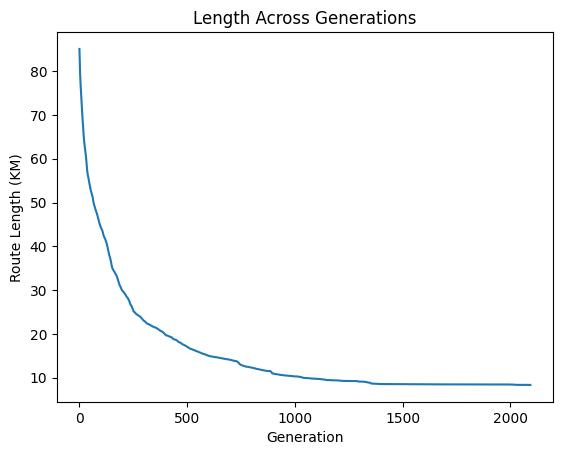

In [16]:
""" Displays information relevant to the output of the EA.
"""

print("Best Individual:", route)
print("Best Fitness:", evaluation.fitness(route, bin_info, model.eval_type), "    Target Fitness:", target_fitness)
print("Best Route Length:", round(route_distance, 2),"KM\n")

try:
    fitness_increase = ((sum(fitness) - sum(fitness_o)) / sum(fitness_o))/gen_count
except ZeroDivisionError:
    fitness_increase = 0.0
    
print("Average Improvement Per Generation:",round(fitness_increase*100,2),"% Fitness Increase")
print("Generations to Terminate:", gen_count)
print("Max Generations Allowed", max_gen, "\n")

dist_map = pd.DataFrame({"length": avg_dist})
if(gen_count > 0):
    plt1=sb.lineplot(x=dist_map.index, y='length', data=dist_map).set(title="Length Across Generations", xlabel='Generation', ylabel="Route Length (KM)")
    plt.show()

### Route Visualization

C:\Users\Lucas\AppData\Local\Temp\ipykernel_67288\3828348869.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-go" (-> color='g'). The keyword argument will take precedence.
  ax.plot(longitudes, latitudes, '-go', color='black', linewidth=1)


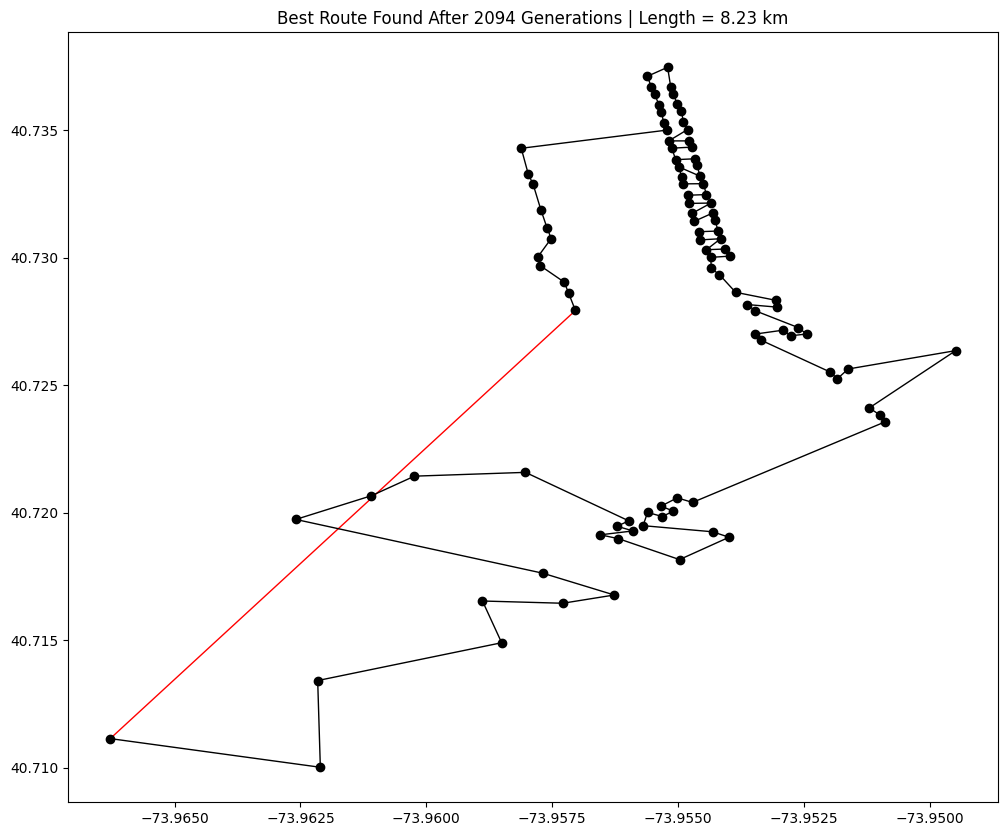

In [17]:
""" Plots the best route with Longitude on the x-axis and Latitude on the y-axis.
Each pair of adjacent bins in an individual are connected via a line.
"""
latitudes = []
longitudes = []
for bin in route:
    lat, lon = bin_info.get_coord(bin)
    latitudes.append(lat)
    longitudes.append(lon)  
    
plt_route, ax = plt.subplots()
ax.plot([longitudes[-1], longitudes[0]], [latitudes[-1], latitudes[0]], color='red', linewidth=1)    
ax.plot(longitudes, latitudes, '-go', color='black', linewidth=1)    
plt.title(label=("Best Route Found After " +  str(gen_count) +  " Generations | Length = " + str(round(route_distance,2)) + " km"))

plt_route.set_size_inches(12, 10)    
plt.show()

### Statistical Information

In [13]:
import statistics as st
from scipy.stats import norm
import time

bin_info = environment.BinInfo('../datasets/BinLocations_Small.csv', '../datasets/BinDistances_Small.csv')

distances_pmx = []
distances_ex= []
fitness_increase_pmx = []
fitness_increase_ex = []
terminate_pmx = []
terminate_ex = []

rep = 100 # Amount of times to run model
max_gen = 250
og_time = time.time()

# Runs model using PMX
for _ in range(rep):
    model = BinsEA(bin_info, 120, 80, 20, 0.3, 0.7, max_gen, 5, 0)
    population, fitness, fitness_o, gen_count, _ = model.get_output(display=False)
    terminate_pmx.append(gen_count)
    route = population[fitness.index(max(fitness))]
    dist = 0
    for bin in range(len(route)-1):
        dist += bin_info.get_dist(route[bin], route[bin+1])
    distances_pmx.append(dist)
    fitness_increase_pmx.append(((sum(fitness) - sum(fitness_o)) / sum(fitness_o))/gen_count)

pmx_time = time.time()

# Runs model using Edge Crossover
for _ in range(rep):
    model = BinsEA(bin_info, 120, 80, 20, 0.3, 0.7, max_gen, 5, 1)
    population, fitness, fitness_o, gen_count, _ = model.get_output(display=False)
    terminate_ex.append(gen_count)
    route = population[fitness.index(max(fitness))]
    dist = 0
    for bin in range(len(route)-1):
        dist += bin_info.get_dist(route[bin], route[bin+1])
    distances_ex.append(dist)
    fitness_increase_ex.append(((sum(fitness) - sum(fitness_o)) / sum(fitness_o))/gen_count)

print("\nTime taken to run EA", rep, "times with PMX:", round(pmx_time - og_time, 2), "seconds")
print("Time taken to run EA", rep, "times with Edge:", round(time.time() - pmx_time, 2), "seconds", "\n")

print("PMX - Small Dataset\n")

mean = st.mean(distances_pmx)
dev = st.stdev(distances_pmx)
print("Mean Distance:", mean, "km")
print("Standard Deviation:", dev, "km")
print("Maximum Distance:", max(distances_pmx), "km | Minimum Distance:", min(distances_pmx), "km\n")

mean = st.mean(fitness_increase_pmx)
dev = st.stdev(fitness_increase_pmx)
print("Mean Fitness Increase per Generation:", mean*100, "%")

mean = st.mean(terminate_pmx)
print("Average generations to terminate (max =", max_gen, "):", mean)


print("\nEdge - Small Dataset\n")

mean = st.mean(distances_ex)
dev = st.stdev(distances_ex)
print("Mean Distance:", mean)
print("Standard Deviation:", dev)
print("Maximum Distance:", max(distances_ex), "km | Minimum Distance:", min(distances_ex), "km\n")

mean = st.mean(fitness_increase_ex)
print("Mean Fitness Increase per Generation:", mean*100, "%")

mean = st.mean(terminate_ex)
print("Average generations to terminate (max =", max_gen, "):", mean)


Time taken to run EA 100 times with PMX: 16.2 seconds
Time taken to run EA 100 times with Edge: 24.02 seconds 

PMX - Small Dataset

Mean Distance: 2.89809347871451 km
Standard Deviation: 0.08314451537878778 km
Maximum Distance: 2.998098810685666 km | Minimum Distance: 2.673449638733703 km

Mean Fitness Increase per Generation: 5.4639518294205605 %
Average generations to terminate (max = 250 ): 39.13

Edge - Small Dataset

Mean Distance: 2.8964174743527797
Standard Deviation: 0.08242942778432474
Maximum Distance: 2.9988513654909057 km | Minimum Distance: 2.664502396435469 km

Mean Fitness Increase per Generation: 4.71615206402707 %
Average generations to terminate (max = 250 ): 46.99


#### SHAP Results

In [44]:
import shap
import shap.maskers
import copy

bin_info = environment.BinInfo('../datasets/BinLocations_Small.csv', '../datasets/BinDistances_Small.csv')

# Given a subset of Location data, runs the EA and returns the best route found.
def shap_runner(input_info):
    bin_copy = copy.deepcopy(bin_info)
    bin_copy.bins = input_info.tolist()

    model = BinsEA(bin_info=bin_copy, max_gen=250, eval_type=1)
    population, fitness, _, _, _ = model.get_output(display=False)

    return np.array(population[fitness.index(max(fitness))])

input_info = copy.deepcopy(bin_info.bins)
for c in input_info:
    del c[2]
    del c[1]
input_info = np.array(input_info)
output_info = np.array(route)
masker = shap.maskers.Independent(data=input_info[:2])
explainer = shap.PermutationExplainer(shap_runner, masker=masker)
shap_vals = explainer(input_info)

PermutationExplainer explainer: 16it [17:26, 69.77s/it]                        


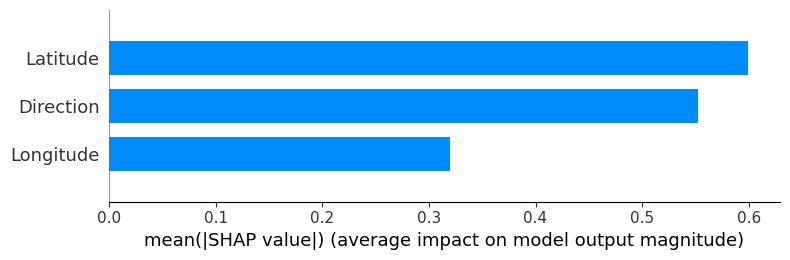

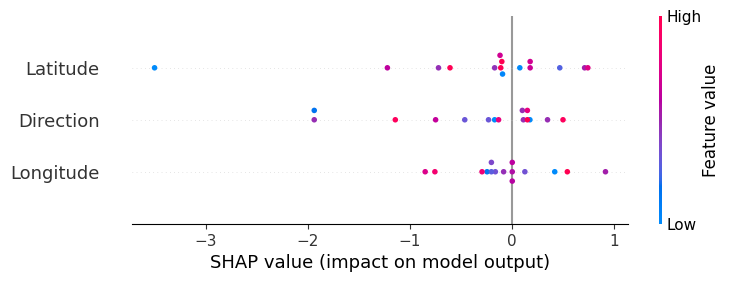

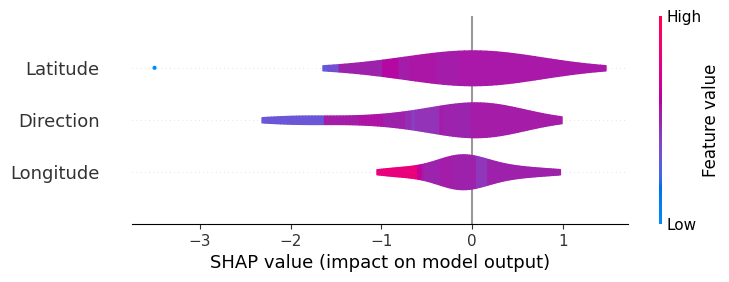

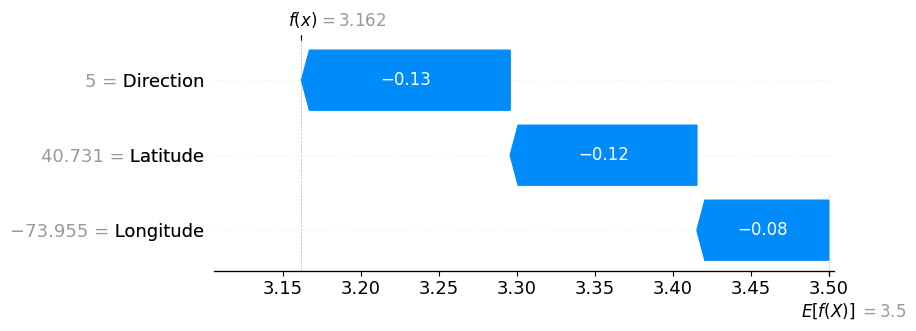

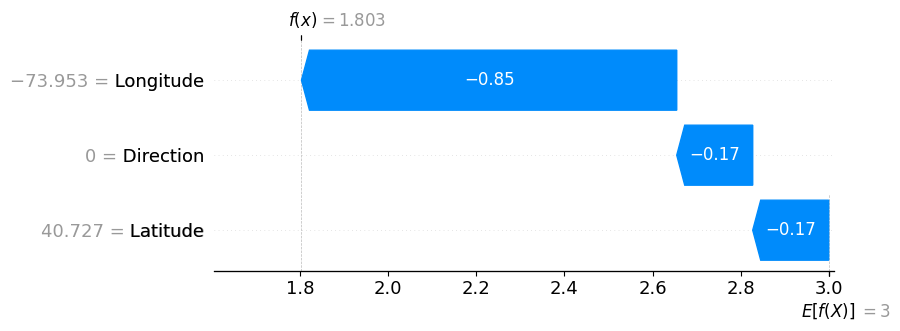

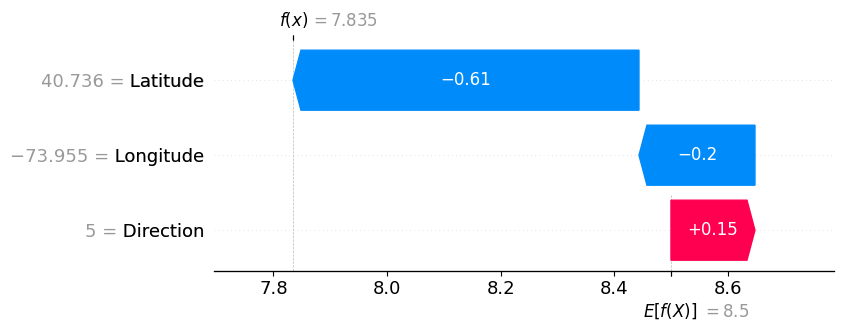

In [45]:
shap_vals.feature_names = ["Direction", "Latitude", "Longitude"]
shap.summary_plot(shap_values=shap_vals, plot_type='bar')
shap.plots.beeswarm(shap_vals)
shap.plots.violin(shap_vals)
shap.plots.waterfall(shap_values=shap_vals[0])
shap.plots.waterfall(shap_values=shap_vals[1])
shap.plots.waterfall(shap_values=shap_vals[2])

#### DiCE Results

In [46]:

import dice_ml
from dice_ml.utils import helpers
from sklearn.model_selection import train_test_split

"""In the end, DiCE is not compatable with the EA as it exists now, despite many attempts being made
to get it to work. The commented out code below shows how it was tested, and the issues that prevented
it from working are discussed in depth in the report.

dataset = copy.deepcopy(bin_info.bins)
for row in range(len(dataset)):
    dataset[row].append(route.index(row))
cols = copy.deepcopy(bin_info.headers)
cols.append("route_pos")
bin_data = pd.DataFrame(dataset, columns=cols)
bin_data = bin_data.drop(["streetname1","streetname2"],axis=1)
target = bin_data["route_pos"]
train, test, _, _ = train_test_split(bin_data, target, test_size=0.2, random_state=0)


d = dice_ml.Data(dataframe=train, continuous_features=['point_latitude', 'point_longitude'], outcome_name='route_pos')
m = dice_ml.Model(model=BinsEA, backend='TF2', func='ohe-min-max')
exp = dice_ml.Dice(d,m)

query_instance = test.drop(columns="route_pos")[0:1]

dice_exp = exp.generate_counterfactuals(query_instance, 4, "opposite")
dice_exp.visualize_as_dataframe()"""


'In the end, DiCE is not compatable with the EA as it exists now, despite many attempts being made\nto get it to work. The commented out code below shows how it was tested, and the issues that prevented\nit from working are discussed in depth in the report.\n\ndataset = copy.deepcopy(bin_info.bins)\nfor row in range(len(dataset)):\n    dataset[row].append(route.index(row))\ncols = copy.deepcopy(bin_info.headers)\ncols.append("route_pos")\nbin_data = pd.DataFrame(dataset, columns=cols)\nbin_data = bin_data.drop(["streetname1","streetname2"],axis=1)\ntarget = bin_data["route_pos"]\ntrain, test, _, _ = train_test_split(bin_data, target, test_size=0.2, random_state=0)\n\n\nd = dice_ml.Data(dataframe=train, continuous_features=[\'point_latitude\', \'point_longitude\'], outcome_name=\'route_pos\')\nm = dice_ml.Model(model=BinsEA, backend=\'TF2\', func=\'ohe-min-max\')\nexp = dice_ml.Dice(d,m)\n\nquery_instance = test.drop(columns="route_pos")[0:1]\n\ndice_exp = exp.generate_counterfactuals(q

#### ALE Results

array([[<Axes: xlabel='Direction', ylabel='ALE'>,
        <Axes: xlabel='Latitude', ylabel='ALE'>,
        <Axes: xlabel='Longitude', ylabel='ALE'>]], dtype=object)

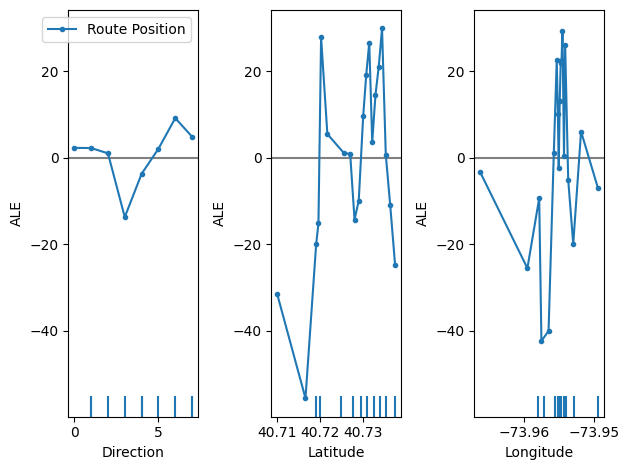

In [48]:
from alibi.explainers import ALE
from alibi.explainers import plot_ale
import copy

bin_info = environment.BinInfo('../datasets/BinLocations_Medium.csv', '../datasets/BinDistances_Medium.csv')

# Runs EA using input_info, returns best route found.
def ale_runner(input_info):
    bin_copy = copy.deepcopy(bin_info)
    bin_copy.bins = input_info.tolist()
    model = BinsEA(bin_info=bin_copy, max_gen=3500, eval_type=1)
    population, fitness, _, _, _ = model.get_output(display=False)
    return np.array(population[fitness.index(max(fitness))])

input_info = copy.deepcopy(bin_info.bins)
for c in input_info:
    del c[2]
    del c[1]
input_info = np.array(input_info)
ale = ALE(ale_runner, feature_names=["Direction", "Latitude", "Longitude"], target_names=["Route Position"])
exp = ALE.explain(ale, X=input_info)
plot_ale(exp)
